In [1]:
#Import relevant modules
import numpy as np
import pandas as pd
import zipfile

In [2]:
city_name = 'Anaheim'
percentile_val = 98
main_zip = 'Alpha_Objective/' + city_name + '/' + city_name + '-'
main_zip_loc = 'Alpha_Objective/' + city_name + '/'
edges_file = 'Locations/' + city_name + '/edges.csv'
new_folder = 'Alpha_Objective'
specific_city = city_name + '.zip'
od_file = 'Locations/' + city_name + '/od.csv'

In [3]:
with zipfile.ZipFile(specific_city, 'r') as zip_ref:
    zip_ref.extractall(new_folder)

In [4]:
alpha_values = ['0', '.05', '.10', '.15', '.20', '.25', '.30', '.35', '.40', '.45', '.50',
               '.55', '.60', '.65', '.70', '.75', '.80', '.85', '.90', '.95', '1.00']

#Edges Data
edges = pd.read_csv(edges_file)
edges_arr = np.array(edges)
edges_arr = np.c_[edges_arr, np.array(range(len(edges)))]

OD_mat = pd.read_csv(od_file)
OD_arr__ = OD_mat['volume'].values

total_cost = []
final_beta = []
percentile_beta = []
for alpha_val in alpha_values:
    print(alpha_val)
    with zipfile.ZipFile(main_zip+alpha_val+'.zip', 'r') as zip_ref:
        zip_ref.extractall(main_zip_loc)
        
    df_flow = pd.read_csv(main_zip+alpha_val+'/flow.csv', skiprows = 1)
    actual_cost = np.array(df_flow['actualCost'])
    flow = np.array(df_flow['flow'])
    total_cost.append(sum([actual_cost[i]*flow[i] for i in range(len(actual_cost))]))
    

    flow_arr = np.array(df_flow)

    def find_edge2(tail_, head_):
        '''Finds edge index for given edge'''

        edges_filtered = edges_arr[edges_arr[:, 0] == tail_]
        edges_filtered = edges_filtered[edges_filtered[:, 1] == head_]

        return edges_filtered[0, -1]

    #Update Flow data
    edge_num_arr = []
    for j in df_flow.index:
        tail_value = int(flow_arr[j, 1])
        head_value = int(flow_arr[j, 2])
        edge_num_arr.append(find_edge2(tail_value, head_value))

    flow_arr = np.c_[flow_arr, edge_num_arr]
    flow_arr = flow_arr[flow_arr[:,-1].argsort()]
    
    cost_sol = flow_arr[:, 4]
    cost_sol = np.array([float(i) for i in cost_sol])
    
    paths_df = pd.read_csv(main_zip+alpha_val+'/paths.csv', sep='delimiter', header=None)
    paths_df = paths_df.iloc[2:]
    paths_df = paths_df[0].str.split(',', 2, expand = True)
    paths_arr = np.array(paths_df)
    
    weights_df = pd.read_csv(main_zip+alpha_val+'/weights.csv', skiprows = 1)
    weights_df_arr = np.array(weights_df)

    #Check if weight is at least 1/10th of the maximum weight
    small_arr = []
    for i in range(len(weights_df_arr)):
        if weights_df_arr[i, 1] > max(weights_df_arr[:, 1])/10:
            small_arr.append(i)

    paths_arr[:, 0] = [int(i) for i in paths_arr[:, 0]]
    #paths_arr_ue = np.append(paths_arr_ue, np.array(weig), axis=1)
    paths_arr = paths_arr[paths_arr[:, 0]>=min(small_arr)]
    paths_arr_new = paths_arr[:, 1:]
    paths_arr_new = np.vstack({tuple(row) for row in paths_arr_new})
    
    beta_val = []
    for OD_pair in range(int(paths_arr[-1, 1])):
        OD_arr = paths_arr_new[paths_arr_new[:, 0] == str(OD_pair)]
        all_paths_OD = []
        OD_tt_paths = []
        for path_idx, path_val in enumerate(OD_arr[:, 1]):
            all_edges = path_val.split(',')
            all_edges = [int(i) for i in all_edges]
            list_edges = []
            path_tt = 0
            for edge_values in all_edges:
                list_edges.append(edge_values)
                path_tt += cost_sol[edge_values]
            OD_tt_paths.append(path_tt)

        #Store max and min paths per OD pair
        path_OD_max = max(OD_tt_paths)
        path_OD_min = min(OD_tt_paths)

        #Find ratio of max and min
        path_OD_beta = path_OD_max/path_OD_min
        beta_val.append(path_OD_beta)
        
        #Find percentile value of beta for this value of alpha
    beta_new_val = [item for item, count in zip(beta_val, OD_arr__) for i in range(count)]
    beta_dist = np.percentile(beta_new_val, percentile_val)

    #Find maximum value of beta for this value of alpha
    beta = max(beta_val) 
    final_beta.append(beta)
    percentile_beta.append(beta_dist)

0


/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/Users/devanshjalota/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


.05
.10
.15
.20
.25
.30
.35
.40
.45
.50
.55
.60
.65
.70
.75
.80
.85
.90
.95
1.00


In [5]:
import matplotlib.pyplot as plt
alpha_vals_plot = [float(i) for i in alpha_values]
plt.plot(alpha_values, total_cost)
plt.xlabel(r'$\alpha$')
plt.ylabel('Total Travel Time')

Text(0, 0.5, 'Total Travel Time')

Text(0, 0.5, '$\\beta$')

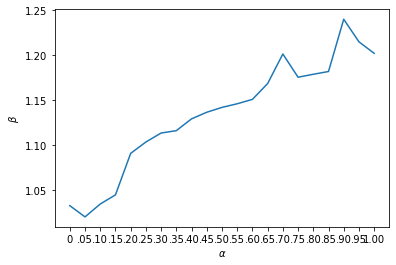

In [6]:
plt.plot(alpha_values, final_beta)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, 'Total Travel Time')

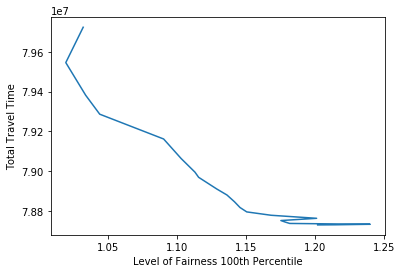

In [7]:
plt.plot(final_beta, total_cost)
plt.xlabel('Level of Fairness {}th Percentile'.format(100))
plt.ylabel('Total Travel Time')

Text(0, 0.5, '$\\beta$')

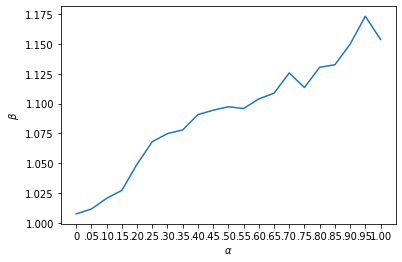

In [8]:
plt.plot(alpha_values, percentile_beta)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, 'Total Travel Time')

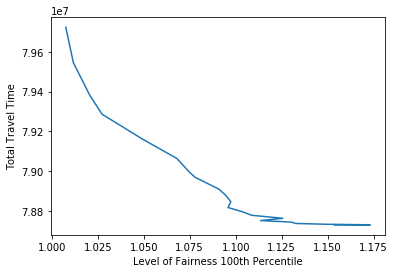

In [9]:
plt.plot(percentile_beta, total_cost)
plt.xlabel('Level of Fairness {}th Percentile'.format(100))
plt.ylabel('Total Travel Time')